In [1]:
#https://math.stackexchange.com/questions/3280757/differentiable-top-k-function\
#https://gist.github.com/thomasahle/4c1e85e5842d01b007a8d10f5fed3a18

import torch
from functorch import vmap, grad
from torch.autograd import Function

sigmoid = torch.sigmoid
sigmoid_grad = vmap(vmap(grad(sigmoid)))

class TopK(Function):
    @staticmethod
    def forward(ctx, xs, k):
        ts, ps = _find_ts(xs, k)
        ctx.save_for_backward(xs, ts)
        return ps

    @staticmethod
    def backward(ctx, grad_output):
        # Compute vjp, that is grad_output.T @ J.
        xs, ts = ctx.saved_tensors
        # Let v = sigmoid'(x + t)
        v = sigmoid_grad(xs + ts)
        s = v.sum(dim=1, keepdims=True)
        # Jacobian is -vv.T/s + diag(v)
        uv = grad_output * v
        t1 = - uv.sum(dim=1, keepdims=True) * v / s
        return t1 + uv, None

@torch.no_grad()
def _find_ts(xs, k):
    b, n = xs.shape
    assert 0 < k < n
    # Lo should be small enough that all sigmoids are in the 0 area.
    # Similarly Hi is large enough that all are in their 1 area.
    lo = -xs.max(dim=1, keepdims=True).values - 10
    hi = -xs.min(dim=1, keepdims=True).values + 10
    for _ in range(64):
        mid = (hi + lo)/2
        mask = sigmoid(xs + mid).sum(dim=1) < k
        lo[mask] = mid[mask]
        hi[~mask] = mid[~mask]
    ts = (lo + hi)/2
    return ts, sigmoid(xs + ts)

topk = TopK.apply
xs = torch.randn(2, 3)
ps = topk(xs, 2)
print(xs, ps, ps.sum(dim=1))

# from torch.autograd import gradcheck
# input = torch.randn(20, 10, dtype=torch.double, requires_grad=True)
# for k in range(1, 10):
#     print(k, gradcheck(topk, (input, k), eps=1e-6, atol=1e-4))

tensor([[-0.7969,  0.1438,  0.6465],
        [-1.6325, -0.7035, -0.4010]]) tensor([[0.4884, 0.7098, 0.8017],
        [0.5036, 0.7198, 0.7766]]) tensor([2.0000, 2.0000])


In [56]:
# Test speed
xs = torch.abs(torch.randn(40,500).float().cuda())
xsorig = xs.detach().clone()
for _ in range(1):
    ps = topk(xs, 10)

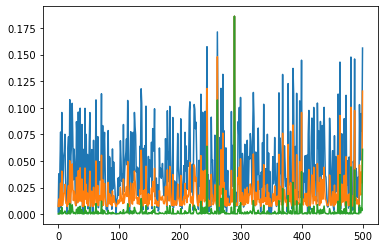

In [58]:
import matplotlib.pyplot as plt

mxs, _ = torch.max(ps, dim=1, keepdim=True)
mxsorig, _ = torch.max(xsorig, dim=1, keepdim=True)

sx = F.softmax(xs*2, dim=1)
msx, _ = torch.max(sx, dim=1, keepdim=True)

plt.plot((xsorig*mxs/mxsorig)[0].detach().cpu().numpy())
plt.plot(ps[0].detach().cpu().numpy())
plt.plot((sx*mxs/msx)[0].detach().cpu().numpy())
plt.show()

In [4]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [5]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [6]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [7]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [8]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [9]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [222]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

mu_age = torch.mean(age_t)
sd_age = torch.std(age_t)

mu_wrt = torch.mean(wrt_t)

age_t = (age_t - mu_age)
wrt_t = (wrt_t - mu_wrt)

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [240]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    avg = 0
    for para in range(nPara):
        avg += res[para]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, inp, dp=0.5, edp=0, wInit=1e-4, k=20, kIter=1, temp=1):
        super(LatSim, self).__init__()
        self.B = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],2).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.k = k
        self.kIter = kIter
        self.temp = temp
        
    def getEdges(self, X, para):
        e = 1e-10
        z = X[:,para,:]@self.B[para]
        e = e+z@z.T
        return e
    
    def forward(self, x, y, testIdcs=None, temp=None):
        if temp is not None:
            self.temp = temp
        x = self.dp(x)
        res = []
        es = []
        for para in range(2):
            e = self.getEdges(x, para)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = mask(e)
            e = self.edp(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e/self.temp, dim=1)
#             for _ in range(self.kIter):
#                 p = topk(e, self.k)
#                 e = p*e
            res.append(e@y)
            es.append(e)
        return res, es
    
def validate(model, X, y, testIdcs):
    model.eval()
    loss = None
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        r = getAvg(res)
        if y.dim() == 1:
            loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
nEpochs = 100
pPeriod = 5
thresh = 0.3
binParam = 0

for rep in range(1):
    for grp in range(10):
        trainIdcs = groups[grp][0][0:496]
        trainValidIdcs = groups[grp][0]
        validIdcs = np.arange(496,len(trainValidIdcs))
        testIdcs = groups[grp][1]

        X0 = nback_p_t
        X1 = emoid_p_t

        X = torch.stack([X0, X1], dim=1)
        Xt = X[trainIdcs]
        Xtv = X[trainValidIdcs]

        yy = wrt_t
        yt = yy[trainIdcs]
        ytv = yy[trainValidIdcs]
        
        tempStart = 5
        tempEnd = 1/5
        tempSav = None

        sim = LatSim(X, dp=0.5, edp=0.1, wInit=1e-4)
        optim = torch.optim.Adam(sim.parameters(), lr=5e-5, weight_decay=5e-5)

        validLoss = []

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, _ = sim(Xt, yt, temp=((nEpochs-epoch)*tempStart+(epoch)*tempEnd)/nEpochs)
            loss = []
            for i,(r,y) in enumerate(zip(res+[getAvg(res)], 3*[yt])):
                if y.dim() > 1:
                    loss.append(ceLoss(r, y))
                else:
                    loss.append(mseLoss(r, y))
            sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or all([ls < thresh for ls in loss]):
#                 print(f'epoch {epoch} loss={loss}')
                loss = validate(sim, Xtv, ytv, validIdcs)
                if (len(validLoss) == 0 or 
                        (y.dim() == 1 and loss < min(validLoss)) or 
                        (y.dim() > 1 and loss > max(validLoss))):
                    print(f'New best validation epoch {epoch} loss={loss}')
                    torch.save(sim.state_dict(), f'../../Work/LatentSim/sim.pyt')
                    tempSav = sim.temp
                    validLoss.append(float(loss))
                if loss < thresh:
                    print('Early stopping')
                    break


        sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim.pyt'))
        sim.temp = tempSav
        loss = validate(sim, X, yy, testIdcs)

        rmse.append(float(loss))

        print(f'FINISHED {rmse}')

New best validation epoch 0 loss=12.037636756896973
New best validation epoch 5 loss=11.824006080627441
New best validation epoch 10 loss=11.777632713317871
New best validation epoch 30 loss=11.730772972106934
New best validation epoch 35 loss=11.53183650970459
FINISHED [12.956769943237305]
New best validation epoch 0 loss=11.887045860290527
New best validation epoch 5 loss=11.612748146057129
New best validation epoch 10 loss=11.51103687286377
New best validation epoch 25 loss=11.343132972717285
New best validation epoch 30 loss=10.965093612670898
New best validation epoch 35 loss=10.926697731018066
FINISHED [12.956769943237305, 13.027962684631348]
New best validation epoch 0 loss=12.063644409179688
New best validation epoch 5 loss=11.94633674621582
New best validation epoch 10 loss=11.695136070251465
New best validation epoch 25 loss=11.619338035583496
New best validation epoch 30 loss=11.407923698425293
New best validation epoch 35 loss=11.338425636291504
FINISHED [12.956769943237305

In [241]:
sum(rmse)/len(rmse)

14.458197498321534

In [242]:
sim.eval()
with torch.no_grad():
    sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim.pyt'))
    res, es = sim(X, yy, testIdcs)
sim.train()

print(len(res))
print(len(es))

2
2


42.409677419354836
5.676266193389893


/tmp/ipykernel_8445/4118279406.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


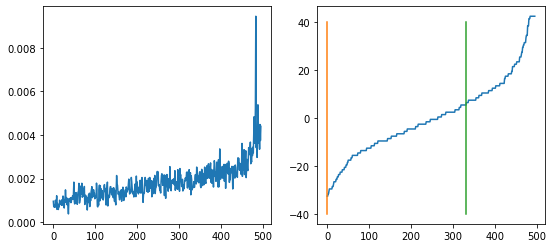

In [254]:
import matplotlib.pyplot as plt

ageA = wrt - np.mean(wrt)
res0 = res[0][:].detach().cpu().numpy()
es0 = es[0][:,trainIdcs].detach().cpu().numpy()

idcs = np.argsort(ageA[trainIdcs])

testIdx = testIdcs[36]

ageTrainSorted = ageA[trainIdcs][idcs]

idx = np.argmax(ageTrainSorted>ageA[testIdx])
idx2 = np.argmax(ageTrainSorted>float(res0[testIdx]))

print(ageA[testIdx])
print(float(res[0][testIdx]))

fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(es0[testIdx,idcs])

ax[1].plot(ageTrainSorted)
ax[1].plot([idx,idx],[-40,40])
ax[1].plot([idx2,idx2],[-40,40])

fig.show()

In [237]:
sim.temp

4.1425